In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/My Drive/embedding_fin.csv', index_col=0)
df.head()

,노출(분),상품군,판매단가,취급액,판매수량,결제유형,성별,18k,cerini_by_pat,ih,lg,nnf,pk,set,swiss,tv,uspa,가스레인지,가스와이드그릴,가이거,갈치,고등어,국내산,그렉노먼,극세사,금고,기능성,기모,기초세트,김치,냄비,냉장고,노트북,녹용도가니탕,뉴스파,니트,대동모피,대우전자,더블,데님,...,쿠미투니카,쿠첸,쿠커,쿠쿠,크로스백,크리스티나앤코,클란츠,키친플라워,테이트,토트백,트랙수트,트렁크,트레이닝,트레킹화,티셔츠,파뷔에,팔찌,패딩,패키지,팬츠,팬티,폴로셔츠,푸마,풀세트,풀커버,풍기인견,프라다,프라이팬,프리미엄,한샘,한일,항균,해피콜,헤드,헤비추얼,헤스티지,홈멀티,화이트라벨,후드,흙침대
방송일시,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01 06:00:00,20.0,의류,39900,2099000.0,52.606516,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-01-01 06:00:00,20.0,의류,39900,4371000.0,109.548872,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-01-01 06:20:00,20.0,의류,39900,3262000.0,81.754386,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-01-01 06:20:00,20.0,의류,39900,6955000.0,174.310777,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-01-01 06:40:00,20.0,의류,39900,6672000.0,167.218045,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
!git clone https://github.com/BigcontestParrot2020/csv.git

os.chdir('csv/')
df2 = pd.read_csv('0921_ver.csv', encoding = 'utf-8', index_col = 0).iloc[:,1:]
df2 = df2.dropna()

Cloning into 'csv'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.


In [ ]:
df2.head()

,상품명,상품군,판매단가,취급액,월,일,시,소비층,요일,휴일,프라임,파트
방송일시,,,,,,,,,,,,
2019-01-01 06:00:00,테이트 남성 셀린니트3종,의류,39900,2099000.0,1,1,6,1,Tuesday,2,4,First
2019-01-01 06:00:00,테이트 여성 셀린니트3종,의류,39900,4371000.0,1,1,6,1,Tuesday,2,4,First
2019-01-01 06:20:00,테이트 남성 셀린니트3종,의류,39900,3262000.0,1,1,6,1,Tuesday,2,4,Middle
2019-01-01 06:20:00,테이트 여성 셀린니트3종,의류,39900,6955000.0,1,1,6,1,Tuesday,2,4,Middle
2019-01-01 06:40:00,테이트 남성 셀린니트3종,의류,39900,6672000.0,1,1,6,1,Tuesday,2,4,Later


In [ ]:
data = pd.merge(df2.iloc[:,-8:], df, how = 'outer', left_index=True, right_index=True)
data.head()

,월,일,시,소비층,요일,휴일,프라임,파트,노출(분),상품군,판매단가,취급액,판매수량,결제유형,성별,18k,cerini_by_pat,ih,lg,nnf,pk,set,swiss,tv,uspa,가스레인지,가스와이드그릴,가이거,갈치,고등어,국내산,그렉노먼,극세사,금고,기능성,기모,기초세트,김치,냄비,냉장고,...,쿠미투니카,쿠첸,쿠커,쿠쿠,크로스백,크리스티나앤코,클란츠,키친플라워,테이트,토트백,트랙수트,트렁크,트레이닝,트레킹화,티셔츠,파뷔에,팔찌,패딩,패키지,팬츠,팬티,폴로셔츠,푸마,풀세트,풀커버,풍기인견,프라다,프라이팬,프리미엄,한샘,한일,항균,해피콜,헤드,헤비추얼,헤스티지,홈멀티,화이트라벨,후드,흙침대
방송일시,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01 06:00:00,1,1,6,1,Tuesday,2,4,First,20.0,의류,39900,2099000.0,52.606516,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-01-01 06:00:00,1,1,6,1,Tuesday,2,4,First,20.0,의류,39900,4371000.0,109.548872,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-01-01 06:00:00,1,1,6,1,Tuesday,2,4,First,20.0,의류,39900,2099000.0,52.606516,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-01-01 06:00:00,1,1,6,1,Tuesday,2,4,First,20.0,의류,39900,4371000.0,109.548872,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-01-01 06:20:00,1,1,6,1,Tuesday,2,4,Middle,20.0,의류,39900,3262000.0,81.754386,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
del df2
del df

In [ ]:
df = data
df['log_sales'] = np.log(df.취급액)
df = df.drop(columns = ['취급액', '판매수량'])

In [ ]:
LE_상품군 = LabelEncoder()
LE_요일 = LabelEncoder()
LE_파트 = LabelEncoder()

df.상품군 = LE_상품군.fit_transform(df.상품군)
df.요일 = LE_요일.fit_transform(df.요일)
df.파트 = LE_파트.fit_transform(df.파트)

In [ ]:
mmscaler = MinMaxScaler()

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
import lightgbm as lgb

In [ ]:
clss = list(set(df.상품군))[1:]
month = list(set(df.월))

test_dict = {}
predict_dict = {}
model_dict = {}
mape_dict = {}

for c in clss:
    print(f'===== start training {LE_상품군.inverse_transform([c])} =====')
    train_df = df[df.상품군 == c]
    raw_x = train_df.drop(columns=['log_sales', '상품군'])
    raw_y = train_df[['log_sales','월']]

    test = {}
    predict = {}
    cv_scores = {}
    cv_models = {}

    for m in month:

        try:
            test_x = raw_x[raw_x.월 == m].drop(columns = ['월'])
            test_y = raw_y[raw_y.월 == m].log_sales
            train_x = raw_x.drop(index = test_x.index, columns = ['월'])
            train_y = raw_y.drop(index = test_y.index).log_sales
            
            test_x = mmscaler.fit_transform(test_x)
            train_x = mmscaler.fit_transform(train_x)

            train_y = train_y.to_numpy().reshape(-1)
            test_y = test_y.to_numpy().reshape(-1)
            
            
            params = {'num_leaves' : 500,
                      'learning_rate' : 0.1,
                      # 'boosting_type': 'gbdt',
                      # 'objective': 'tweedie',
                      # 'tweedie_variance_power': 1.1,
                      'metric': 'mape',
                      # 'sub_row' : 0.75,
                      # 'lambda_l2' : 0.1,
                      'categorical_features': [1,2,3,4,5,6,7,8]}

            train_dataset = lgb.Dataset(train_x, train_y)
            test_dataset = lgb.Dataset(test_x, test_y)
            lgbModel = lgb.train(params, train_dataset, 1000, valid_sets = test_dataset, early_stopping_rounds=500, 
                                  verbose_eval = 100)
              
            predict_test = lgbModel.predict(test_x)

            test_y = np.exp(test_y)
            predict_test = np.exp(predict_test)

            test.update({m:test_y})
            predict.update({m: predict_test})

            mape = mean_absolute_percentage_error(test_y, predict_test)
            print(f'{m}월 MAPE:', mape)

            cv_scores.update({m:mape})
            cv_models.update({m:lgb})
      
        except ValueError:
            print(f'{m}월 MAPE: No Value')
            cv_scores.update({m:'no value'})
            cv_models.update({m:'no value'})

        mape_dict.update({c:cv_scores}) 
        model_dict.update({c:cv_models})

        test_dict.update({c:test})
        predict_dict.update({c:predict})
    print(' ')

===== start training ['가전'] =====
Training until validation scores don't improve for 500 rounds.
[100]	valid_0's mape: 0.0484837
[200]	valid_0's mape: 0.0496618
[300]	valid_0's mape: 0.0499871
[400]	valid_0's mape: 0.0503425
[500]	valid_0's mape: 0.0508742
Early stopping, best iteration is:
[9]	valid_0's mape: 0.0412485
1월 MAPE: 99.55567483783386
Training until validation scores don't improve for 500 rounds.
[100]	valid_0's mape: 0.0448726
[200]	valid_0's mape: 0.0468668
[300]	valid_0's mape: 0.0472117
[400]	valid_0's mape: 0.0472633
[500]	valid_0's mape: 0.0472248
Early stopping, best iteration is:
[13]	valid_0's mape: 0.0378698
2월 MAPE: 72.49908179885357
Training until validation scores don't improve for 500 rounds.
[100]	valid_0's mape: 0.0422225
[200]	valid_0's mape: 0.0431129
[300]	valid_0's mape: 0.0434261
[400]	valid_0's mape: 0.0435781
[500]	valid_0's mape: 0.0435358
Early stopping, best iteration is:
[15]	valid_0's mape: 0.0387586
3월 MAPE: 61.011876071949956
Training until val

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_result(group_num):
    fig,  ax = plt.subplots(2,6, figsize = (15, 5))
    for i in range(12):
        x = i//6
        y = i%6
        try:
            ax[x, y].plot(test_dict[group_num][i+1], predict_dict[group_num][i+1], linestyle = '', marker = 'o')
            ax[x, y].plot(test_dict[group_num][i+1], test_dict[group_num][i+1], color = 'r')
            ax[x, y].set_title(f'{i+1}: MAPE {round(mape_dict[group_num][i+1],2)}')
        except KeyError:
            pass

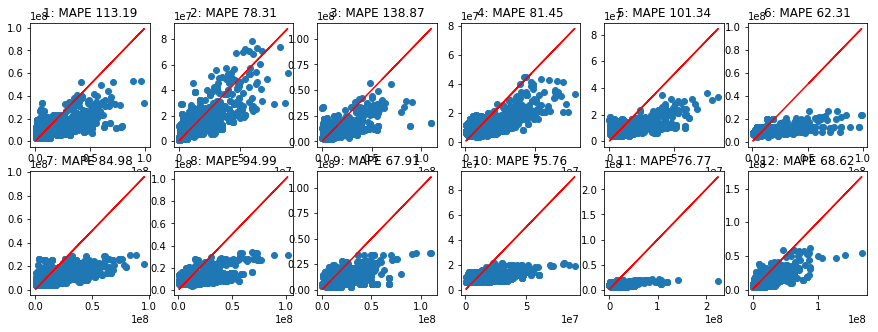

In [ ]:
plot_result(9)

TypeError: ignored

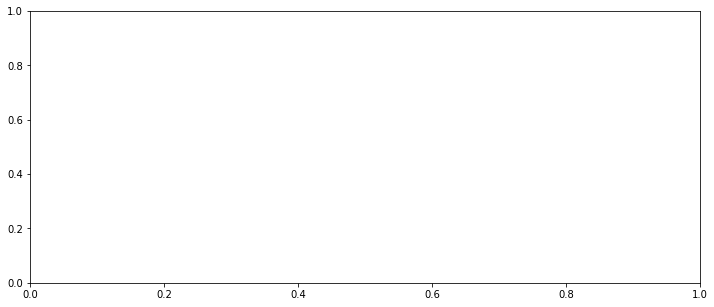

In [ ]:
f, ax = plt.subplots(figsize = (12,5))

from lightgbm import plot_importance
plot_importance(model_dict[7][1], ax, max_num_features=10)

## 시, 판매단가, 분, 요일, 일, 휴일, 프라임, 노출(분), 기초세트, 결제유형

In [ ]:
f, ax = plt.subplots(figsize = (12,5))
plot_importance(model_dict[1][1], ax, max_num_features=10)

# 판매단가, 분, 결제유형, 시, LG, 냉장고, 삼성, 휴일, TV, 일

In [ ]:
df_  = train_df.drop(columns=['log_sales','상품군', '월'])

In [ ]:
df_.columns[204]

'일'

In [ ]:
LE_상품군.inverse_transform([7])

array(['이미용'], dtype=object)